# Training exploration (clean flow)
Two YOLO baselines (nano/small), consolidated results, and per-prediction analysis in one master DataFrame.


In [26]:
%matplotlib inline
from pathlib import Path
import sys
import random
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO


# Normalize project root
PROJECT_ROOT = Path().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
    
from src.training import train_model, evaluate_model
from src.config import Paths, TrainingConfig
from src import data as data_utils

# Dataset (YOLO format). Swap root to try another dataset.
DATASET_ROOT = PROJECT_ROOT / "Poles2025/roadpoles_v1"
paths = Paths(dataset_root=DATASET_ROOT)

# Inference / matching controls
CONF_THRESH = 0.25
IOU_MATCH = 0.5
MAX_EVAL_IMAGES = 400000
DATASET_ROOT


PosixPath('/home/erikhbj/Documents/tdt17/TDT17-snow-pole-detection/Poles2025/roadpoles_v1')

In [27]:
# Define experiments (light -> slightly heavier)
experiments = [
    {"name": "yolov8n_baseline", "model": "yolov8n.pt", "epochs": 3, "batch": 8, "imgsz": 640},
    {"name": "yolov8s_baseline", "model": "yolov8s.pt", "epochs": 3, "batch": 8, "imgsz": 640},
]
experiments


[{'name': 'yolov8n_baseline',
  'model': 'yolov8n.pt',
  'epochs': 3,
  'batch': 8,
  'imgsz': 640},
 {'name': 'yolov8s_baseline',
  'model': 'yolov8s.pt',
  'epochs': 3,
  'batch': 8,
  'imgsz': 640}]

In [28]:
# Helper functions
def metrics_from_results(metrics_obj):
    res = getattr(metrics_obj, "results_dict", {}) or {}
    return {
        "precision": res.get("metrics/precision(B)"),
        "recall": res.get("metrics/recall(B)"),
        "map50": res.get("metrics/mAP50(B)"),
        "map5095": res.get("metrics/mAP50-95(B)"),
    }

def xywh_to_xyxy(xywh):
    cx, cy, w, h = xywh
    return np.array([cx - w/2, cy - h/2, cx + w/2, cy + h/2])

def iou(box1, box2):
    xa, ya = max(box1[0], box2[0]), max(box1[1], box2[1])
    xb, yb = min(box1[2], box2[2]), min(box1[3], box2[3])
    inter = max(0, xb - xa) * max(0, yb - ya)
    area1 = max(0, box1[2]-box1[0]) * max(0, box1[3]-box1[1])
    area2 = max(0, box2[2]-box2[0]) * max(0, box2[3]-box2[1])
    union = area1 + area2 - inter + 1e-9
    return inter / union


In [29]:
# Train and evaluate all experiments
results_rows = []
for exp in experiments:
    print(f"=== Training {exp['name']} ({exp['model']}) ===")
    cfg = TrainingConfig(
        model=exp["model"],
        epochs=exp["epochs"],
        batch=exp["batch"],
        imgsz=exp["imgsz"],
        patience=10,
    )
    train_res = train_model(paths=paths, cfg=cfg, overrides={"name": exp["name"]})
    best_weights = Path(train_res.save_dir) / "weights" / "best.pt"

    metrics = evaluate_model(weights=best_weights, paths=paths, imgsz=cfg.imgsz, batch=cfg.batch)
    m = metrics_from_results(metrics)

    results_rows.append({
        "name": exp["name"],
        "model": exp["model"],
        "train_time_s": getattr(train_res, "train_time_seconds", None),
        "eval_time_s": getattr(metrics, "eval_time_seconds", None),
        "save_dir": str(train_res.save_dir),
        "weights": str(best_weights),
        **m,
    })

results_df = pd.DataFrame(results_rows)
display(results_df.sort_values('map50', ascending=False))


=== Training yolov8n_baseline (yolov8n.pt) ===
New https://pypi.org/project/ultralytics/8.3.231 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.230 🚀 Python-3.13.5 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4090, 24208MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/erikhbj/Documents/tdt17/TDT17-snow-pole-detection/Poles2025/roadpoles_v1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=3, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0,

,name,model,train_time_s,eval_time_s,save_dir,weights,precision,recall,map50,map5095
1,yolov8s_baseline,yolov8s.pt,9.702353,2.066278,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0.488829,0.477876,0.465148,0.214762
0,yolov8n_baseline,yolov8n.pt,9.264525,2.105569,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0.600000,0.026549,0.313958,0.220117


## Aggregate metrics plots
Quick comparison of precision/recall/mAP and time.


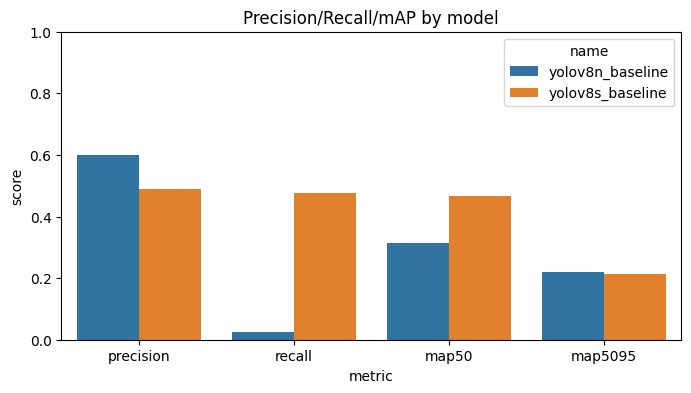

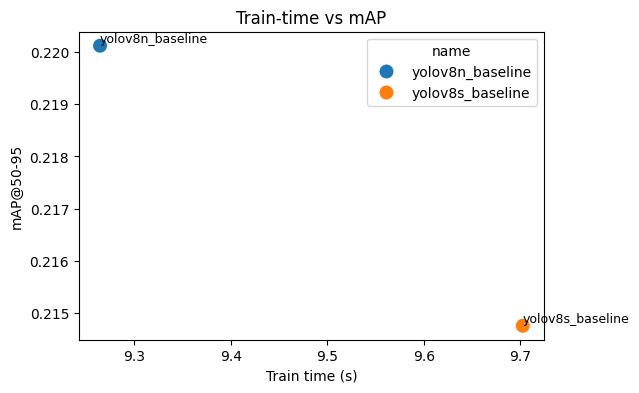

In [30]:
plot_df = results_df.melt(id_vars=['name','model'], value_vars=['precision','recall','map50','map5095'], var_name='metric', value_name='score')
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(data=plot_df, x='metric', y='score', hue='name', ax=ax)
ax.set_title('Precision/Recall/mAP by model')
ax.set_ylim(0, 1)
plt.show()

fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(data=results_df, x='train_time_s', y='map5095', hue='name', s=120, ax=ax)
for _, row in results_df.iterrows():
    ax.text(row['train_time_s'], row['map5095'], row['name'], fontsize=9, ha='left', va='bottom')
ax.set_xlabel('Train time (s)')
ax.set_ylabel('mAP@50-95')
ax.set_title('Train-time vs mAP')
plt.show()


## Per-prediction analysis (single model)
Use the best mAP@50 model to score a subset of val images and build a single consolidated DataFrame of predictions, matches, and metrics.


In [31]:
# Select best model by mAP50
best_row = results_df.sort_values('map50', ascending=False).iloc[0]
weights_path = Path(best_row['weights'])
print(f'Using weights: {weights_path}')
model = YOLO(weights_path)

# Load val annotations
val_df = data_utils.load_annotations('valid', paths.dataset_root)
val_images = val_df['image_path'].dropna().unique().tolist()
print(f'Validation images: {len(val_images)}')
assert val_images, 'No validation images found'

sample_imgs = random.sample(val_images, k=min(MAX_EVAL_IMAGES, len(val_images)))
pred_results = model(sample_imgs, conf=CONF_THRESH, verbose=False)
print(f'Ran inference on {len(sample_imgs)} images')


Using weights: /home/erikhbj/Documents/tdt17/TDT17-snow-pole-detection/notebooks/runs/yolov8s_baseline13/weights/best.pt
Validation images: 92
Ran inference on 92 images


In [32]:
# Build per-prediction DataFrame with GT matching and attach run-level metrics
records = []
for img_path, pred in zip(sample_imgs, pred_results):
    gt_rows = val_df[val_df['image_path'] == Path(img_path)]
    gt_boxes = [xywh_to_xyxy((r.cx, r.cy, r.w, r.h)) for r in gt_rows.itertuples()]
    if pred.boxes is None:
        continue
    pred_xywhn = pred.boxes.xywhn.cpu().numpy()
    pred_conf = pred.boxes.conf.cpu().numpy()
    for idx, (xywh, conf) in enumerate(zip(pred_xywhn, pred_conf)):
        p_box = xywh_to_xyxy(xywh)
        best_iou = 0.0
        best_gt = -1
        for j, g in enumerate(gt_boxes):
            score = iou(p_box, g)
            if score > best_iou:
                best_iou = score; best_gt = j
        records.append({
            'model_name': best_row['name'],
            'image_path': Path(img_path),
            'pred_idx': idx,
            'conf': float(conf),
            'cx': float(xywh[0]), 'cy': float(xywh[1]), 'w': float(xywh[2]), 'h': float(xywh[3]),
            'best_iou': float(best_iou),
            'matched_gt': best_gt if best_iou >= IOU_MATCH else -1,
        })
pred_df = pd.DataFrame(records)
pred_df['hit'] = pred_df['matched_gt'] >= 0

# Attach run-level metrics (duplicated per prediction for convenience)
meta_cols = ['precision','recall','map50','map5095','train_time_s','eval_time_s','weights']
meta = best_row[meta_cols].to_dict()
for k, v in meta.items():
    pred_df[k] = v

display(pred_df.head())
print(f'Total predictions: {len(pred_df)}')


,model_name,image_path,pred_idx,conf,cx,cy,w,h,best_iou,matched_gt,hit,precision,recall,map50,map5095,train_time_s,eval_time_s,weights
0,yolov8s_baseline,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0,0.716984,0.811570,0.644254,0.013103,0.237956,0.712964,1,True,0.488829,0.477876,0.465148,0.214762,9.702353,2.066278,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...
1,yolov8s_baseline,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,1,0.312227,0.812888,0.640251,0.001298,0.230231,0.127744,-1,False,0.488829,0.477876,0.465148,0.214762,9.702353,2.066278,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...
2,yolov8s_baseline,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,2,0.309948,0.813433,0.632983,0.002264,0.213388,0.207548,-1,False,0.488829,0.477876,0.465148,0.214762,9.702353,2.066278,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...
3,yolov8s_baseline,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0,0.262378,0.592281,0.572058,0.004798,0.070135,0.781302,0,True,0.488829,0.477876,0.465148,0.214762,9.702353,2.066278,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...
4,yolov8s_baseline,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0,0.320710,0.660002,0.603665,0.008666,0.134197,0.563508,1,True,0.488829,0.477876,0.465148,0.214762,9.702353,2.066278,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...


Total predictions: 106


### Aggregated prediction quality
Confidence and IoU distributions by hit/miss.


,hit,count,mean
0,False,25,0.393983
1,True,81,0.502863


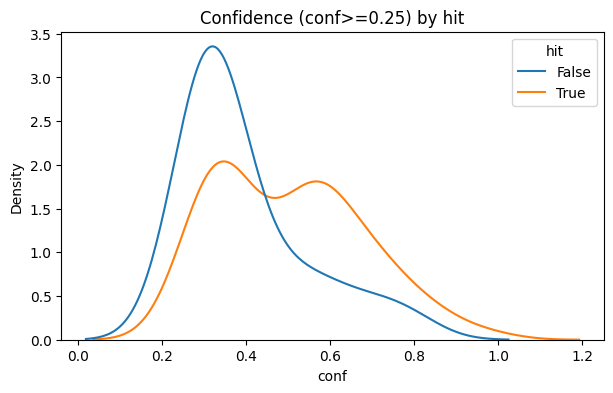

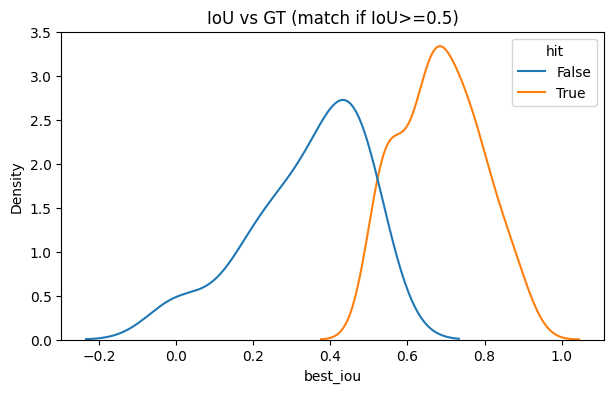

In [33]:
summary = pred_df.groupby('hit')['conf'].agg(['count','mean']).reset_index()
display(summary)

fig, ax = plt.subplots(figsize=(7,4))
sns.kdeplot(data=pred_df, x='conf', hue='hit', common_norm=False, ax=ax)
ax.set_title(f'Confidence (conf>={CONF_THRESH}) by hit')
plt.show()

fig, ax = plt.subplots(figsize=(7,4))
sns.kdeplot(data=pred_df, x='best_iou', hue='hit', common_norm=False, ax=ax)
ax.set_title(f'IoU vs GT (match if IoU>={IOU_MATCH})')
plt.show()


### Visualize one TP and one FP (confidence shaded)


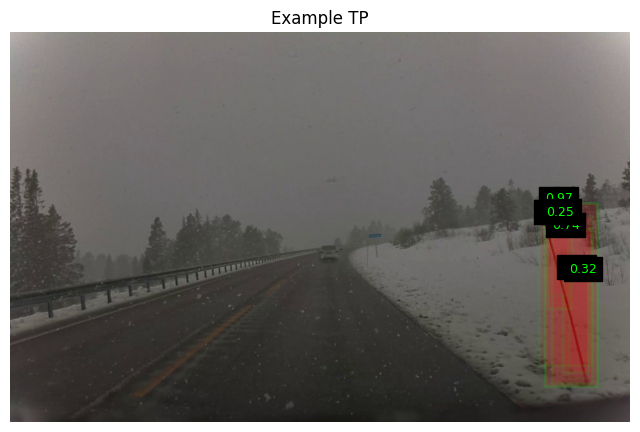

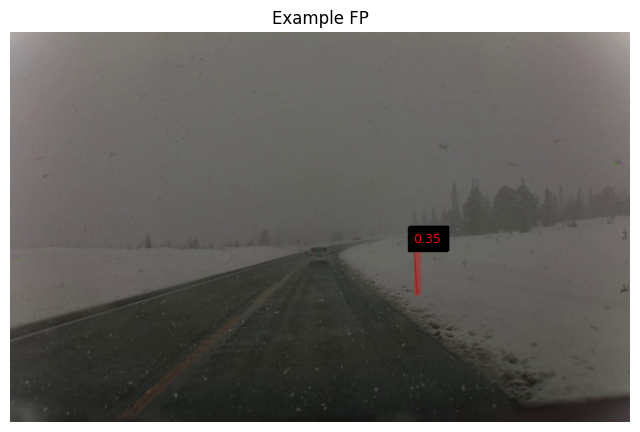

In [34]:
def visualize_prediction(img_path, pred, title, edgecolor='cyan'):
    img = plt.imread(img_path)
    h, w = img.shape[:2]
    fig, ax = plt.subplots(figsize=(8,6))
    ax.imshow(img)
    if pred.boxes is not None:
        xywhn = pred.boxes.xywhn.cpu().numpy()
        confs = pred.boxes.conf.cpu().numpy()
        for (cx, cy, bw, bh), c in zip(xywhn, confs):
            cx_px, cy_px = cx * w, cy * h
            bw_px, bh_px = bw * w, bh * h
            x0, y0 = cx_px - bw_px/2, cy_px - bh_px/2
            alpha = min(max(c, 0.1), 1.0)
            rect = plt.Rectangle((x0, y0), bw_px, bh_px, linewidth=2, edgecolor=edgecolor, facecolor='red', alpha=0.15*alpha)
            ax.add_patch(rect)
            ax.text(x0, y0-2, f'{c:.2f}', color=edgecolor, fontsize=9, backgroundcolor='black')
    ax.set_title(title)
    ax.axis('off')
    plt.show()

# Pick best TP and best FP by confidence
tp_row = pred_df[pred_df['hit']].sort_values('conf', ascending=False).head(1)
fp_row = pred_df[~pred_df['hit']].sort_values('conf', ascending=False).head(1)

def _get_pred_for_image(path_str):
    if path_str in sample_imgs:
        return pred_results[sample_imgs.index(path_str)]
    return None

if not tp_row.empty:
    img_path = tp_row.iloc[0]['image_path']
    pred = _get_pred_for_image(img_path)
    if pred is not None:
        visualize_prediction(img_path, pred, title='Example TP', edgecolor='lime')

if not fp_row.empty:
    img_path = fp_row.iloc[0]['image_path']
    pred = _get_pred_for_image(img_path)
    if pred is not None:
        visualize_prediction(img_path, pred, title='Example FP', edgecolor='red')


In [35]:
fp_row

,model_name,image_path,pred_idx,conf,cx,cy,w,h,best_iou,matched_gt,hit,precision,recall,map50,map5095,train_time_s,eval_time_s,weights
55,yolov8s_baseline,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...,0,0.79143,0.657059,0.604826,0.008365,0.134638,0.442325,-1,False,0.488829,0.477876,0.465148,0.214762,9.702353,2.066278,/home/erikhbj/Documents/tdt17/TDT17-snow-pole-...


### Notes
- `pred_df` is the consolidated "everything" table: predictions + confidence + IoU match + run metrics.
- Adjust `CONF_THRESH`, `IOU_MATCH`, and `MAX_EVAL_IMAGES` up top for stricter/looser analysis.
- For reproducibility, set seeds on sampling/training if needed.
